In [25]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy
import ipynb.fs
import pandas as pd

from ipynb.fs.defs.BCI_COMP_IV_functions import (extractInfo, featureExtraction, createFilterBank,
                                                testFrequencyBand,startRunningClassifier,tuneModelHyperParams,
                                                testWindowStartTime,testClassifier)


In [2]:
dataB = scipy.io.loadmat("BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1b_1000Hz.mat")

dataB["cnt"] = 0.1 * dataB["cnt"].astype(float)

eeg = dataB["cnt"].T 
nChannels, nSamples = eeg.shape

motionIntentComp, idleStateComp = [0,-1], [0,-1]

calibDataStore, testData_motionIntent, _ = featureExtraction(dataB,0.7,motionIntentComp, idleStateComp)

calibData_idle_motionIntent, testData_idle_motionIntent, W_idle_motionIntent = featureExtraction(dataB,0.7,motionIntentComp, idleStateComp,ExtractionType="idle_motionIntent")



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Base Classifiers for detecting Idle State (no resampling)

There is no need to resample because there will always be as many idle states as there are motion intent states

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.ensemble import VotingClassifier


ldaModel = LDA()
SVMmodel = SVC(probability=True, class_weight="balanced")
logRegModel = LogisticRegression(class_weight="balanced")
ensembleClassifier = VotingClassifier(estimators=[('LinearDiscriminantAnalysis', LDA()),
                                                          ('SVC', SVC(probability=True)),
                                                          ('LogisticRegression',LogisticRegression())],
                                                           voting='soft',
                                                           weights=[1,2,1])


In [4]:
nCols = len(calibData_idle_motionIntent.columns)

print("Cross Validation Score")
print("-----------------------")
print("LDA: ",np.mean(cross_val_score(ldaModel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("SVM-LDA-LR: ",np.mean(cross_val_score(ensembleClassifier,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))

print()


Cross Validation Score
-----------------------
LDA:  0.8642857142857142
Logistic Regression:  0.85
SVM:  0.85
SVM-LDA-LR:  0.85



### Tuning Classifiers for detecting Idle State (no resampling)

In the context of predicting between an idle state and a motion intent state, the cost of misclassifying idle state is higher than the cost of misclassifying motion intent state, therefore accuracy alone may not be enough to evaluate the performance of the classifier. Instead, I may need to use a metric that takes into account the false positives and false negatives. The F1 score is a good choice in this case because it balances precision and recall, and provides a single score that reflects the overall performance of the classifier.

In [5]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [6]:
bestMods = tuneModelHyperParams(calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],testData_idle_motionIntent.iloc[:,:nCols-1], testData_idle_motionIntent.iloc[:,nCols-1],votingWeights=[1,2,1])


accuracy
---------

SVC
CV SCORE: 0.8571428571428571

-------------
LogisticRegression
CV SCORE: 0.875

-------------
LinearDiscriminantAnalysis
cv score: 0.8642857142857142

-------------
SVC-LR-LDA
CV SCORE: 0.8464285714285713

-------------


In [7]:
bestMods

defaultdict(dict,
            {'accuracy': {'SVC': (SVC(C=1000, class_weight='balanced', gamma=0.1, probability=True),
               0.8833333333333333),
              'LogReg': (LogisticRegression(C=0.3727593720314938, class_weight='balanced',
                                  solver='liblinear'),
               0.8583333333333333),
              'LDA': (LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr'),
               0.85),
              'SVC_LR_LDA': (VotingClassifier(estimators=[('LinearDiscriminantAnalysis',
                                             LinearDiscriminantAnalysis(shrinkage=0.0,
                                                                        solver='lsqr')),
                                            ('SVC',
                                             SVC(C=1000, class_weight='balanced', gamma=0.1,
                                                 probability=True)),
                                            ('LogisticRegression',
               

In [8]:
bestModel, bestPerformance = None, 0

for metric in bestMods:
    for model in bestMods[metric]:
        mod, perf = bestMods[metric][model]

        if perf > bestPerformance:
            bestModel, bestPerformance = mod, perf


In [9]:
print(bestModel, bestPerformance)

SVC(C=1000, class_weight='balanced', gamma=0.1, probability=True) 0.8833333333333333


In [10]:
idlesStateClassifier = bestModel

In [11]:
idlesStateClassifier 

SVC(C=1000, class_weight='balanced', gamma=0.1, probability=True)

In [12]:
idlestateEnsemble = bestMods["accuracy"]["SVC_LR_LDA"][0]

In [13]:
idlestateEnsemble

VotingClassifier(estimators=[('LinearDiscriminantAnalysis',
                              LinearDiscriminantAnalysis(shrinkage=0.0,
                                                         solver='lsqr')),
                             ('SVC',
                              SVC(C=1000, class_weight='balanced', gamma=0.1,
                                  probability=True)),
                             ('LogisticRegression',
                              LogisticRegression(C=0.3727593720314938,
                                                 class_weight='balanced',
                                                 solver='liblinear'))],
                 voting='soft', weights=[1, 2, 1])

### Base Classifier for classifying motion intent signals

In [14]:

ldaModel = LDA()
SVMmodel = SVC(probability=True,class_weight="balanced")
logRegModel = LogisticRegression(class_weight="balanced")
ensembleClassifier = VotingClassifier(estimators=[('LinearDiscriminantAnalysis', LDA()),
                                                          ('SVC', SVC(probability=True)),
                                                          ('LogisticRegression',LogisticRegression())],
                                                           voting='soft',
                                                           weights=[1,2,1])


In [15]:
for name, calibData in calibDataStore.items():

    nCols = len(calibData.columns)
    print(name,end="\n")
    print("-----------")

    print("LDA: ",np.mean(cross_val_score(ldaModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("SVM-LDA-LR: ",np.mean(cross_val_score(ensembleClassifier,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))

    print()


RO
-----------
LDA:  0.789655172413793
Logistic Regression:  0.7825123152709359
SVM:  0.7830049261083744
SVM-LDA-LR:  0.7899014778325123

SMOTE
-----------
LDA:  0.7967980295566501
Logistic Regression:  0.789655172413793
SVM:  0.7830049261083742
SVM-LDA-LR:  0.7970443349753694

RU
-----------
LDA:  0.7902116402116401
Logistic Regression:  0.7976190476190476
SVM:  0.8047619047619048
SVM-LDA-LR:  0.7973544973544973

CC
-----------
LDA:  0.7828042328042327
Logistic Regression:  0.783068783068783
SVM:  0.7981481481481482
SVM-LDA-LR:  0.8047619047619048

None
-----------
LDA:  0.7928571428571429
Logistic Regression:  0.7928571428571428
SVM:  0.7714285714285715
SVM-LDA-LR:  0.7857142857142857



### Tuned Classification

In the context of distinguishing between left hand motor imagery signals and right hand motor imagery signals, using AUC-ROC as a metric may be more appropriate than F1 score if the classes are imbalanced. AUC-ROC takes into account the true positive rate (sensitivity) and false positive rate (1-specificity) of the model across a range of classification thresholds, which makes it robust to class imbalance.

F1 score, on the other hand, is based on precision and recall and may be affected by class imbalance. If one class is much smaller than the other, the F1 score may be biased towards the larger class.

Therefore, AUC-ROC would be a good choice in this case to evaluate the model's ability to discriminate between the two classes, regardless of class imbalance.

In [16]:
for name, calibData in calibDataStore.items():
    
    bestMods = tuneModelHyperParams(calibData.iloc[:,:nCols-1],
                                    calibData.iloc[:,nCols-1],
                                    testData_motionIntent.iloc[:,:nCols-1],
                                    testData_motionIntent.iloc[:,nCols-1],
                                    votingWeights=[1,2,1]
                                    )
    
    bestModel, bestPerformance = None, 0

    for metric in bestMods:
        for model in bestMods[metric]:
            mod, perf = bestMods[metric][model]

            if perf > bestPerformance:
                bestMetric, bestModel, bestPerformance = metric, mod, perf

    print(name)
    print("-------")
    print(f"Model = {bestModel}, Performance = {bestPerformance}, Metric = {bestMetric} ")
    print()
    print(f"All metrics = {bestMods}")
    print()


accuracy
---------

SVC
CV SCORE: 0.8110837438423646

-------------
LogisticRegression
CV SCORE: 0.8036945812807883

-------------
LinearDiscriminantAnalysis
cv score: 0.8036945812807883

-------------
SVC-LR-LDA
CV SCORE: 0.782512315270936

-------------
RO
-------
Model = VotingClassifier(estimators=[('LinearDiscriminantAnalysis',
                              LinearDiscriminantAnalysis(shrinkage=0.8,
                                                         solver='lsqr')),
                             ('SVC',
                              SVC(C=100, class_weight='balanced', gamma=0.001,
                                  probability=True)),
                             ('LogisticRegression',
                              LogisticRegression(C=0.001,
                                                 class_weight='balanced',
                                                 solver='newton-cg'))],
                 voting='soft', weights=[1, 2, 1]), Performance = 0.8666666666666667, Metric 

### Window Start time test

### Accuracy

accuracy
---------

SVC
CV SCORE: 0.8

-------------
LogisticRegression
CV SCORE: 0.8071428571428572

-------------
LinearDiscriminantAnalysis
cv score: 0.7928571428571429

-------------
SVC-LR-LDA
CV SCORE: 0.7857142857142857

-------------
accuracy
---------

SVC
CV SCORE: 0.7928571428571429

-------------
LogisticRegression
CV SCORE: 0.8

-------------
LinearDiscriminantAnalysis
cv score: 0.7928571428571429

-------------
SVC-LR-LDA
CV SCORE: 0.7857142857142858

-------------
accuracy
---------

SVC
CV SCORE: 0.7714285714285715

-------------
LogisticRegression
CV SCORE: 0.7857142857142857

-------------
LinearDiscriminantAnalysis
cv score: 0.7785714285714285

-------------
SVC-LR-LDA
CV SCORE: 0.75

-------------
accuracy
---------

SVC
CV SCORE: 0.8428571428571429

-------------
LogisticRegression
CV SCORE: 0.8571428571428573

-------------
LinearDiscriminantAnalysis
cv score: 0.85

-------------
SVC-LR-LDA
CV SCORE: 0.8357142857142856

-------------
accuracy
---------

SVC
CV SCO

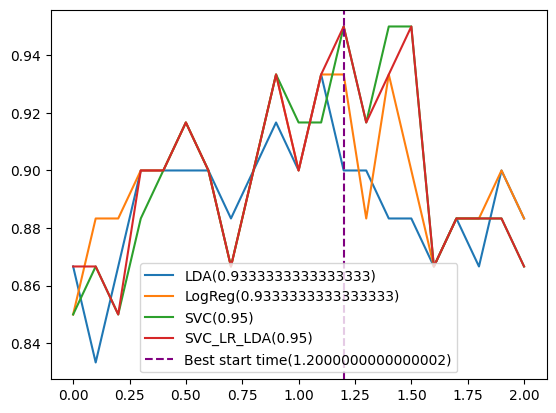

In [17]:
bestEstimator_start_time, W_start_time = testWindowStartTime(dataB,
                                                             0.7,
                                                             4,
                                                             motionIntentComp,
                                                             idleStateComp,
                                                             votingWeights=[1,2,1])


In [18]:
bestEstimator_start_time

SVC(C=100, gamma=0.1, probability=True)

### Investigating the effect of varying the frquency band (for each resampling technique)

In [19]:
channelNames,sRate,classLabels,eventOnsets,eventCodes,labels = extractInfo(dataB,nSamples)

filterBank = createFilterBank(sRate)

freqBandEstimators = {}

In [20]:
#Populate a dictionary with frequency band estimators for each resampling technique

for resamplerType in calibDataStore.keys():
    print(resamplerType)
    print("------------")
    bestBand, bestEstimator_freq_band, (best_b, best_a), W_freq_band, allBandPerformanceMetrics = testFrequencyBand(dataB,
                                                                                         filterBank,
                                                                                         0.7,
                                                                                         motionIntentComp, 
                                                                                         idleStateComp,
                                                                                         trialWinStart=0,
                                                                                         trialWinEnd = 4,
                                                                                         resampler=resamplerType,
                                                                                         votingWeights=[1,2,1])
    
    print()

    freqBandEstimators[resamplerType] = (bestBand, bestEstimator_freq_band, (best_b, best_a), W_freq_band, allBandPerformanceMetrics[bestBand])


RO
------------
accuracy
---------

SVC
CV SCORE: 0.8110837438423646

-------------
LogisticRegression
CV SCORE: 0.8036945812807883

-------------
LinearDiscriminantAnalysis
cv score: 0.8036945812807883

-------------
SVC-LR-LDA
CV SCORE: 0.7896551724137931

-------------
8-12 : 0.85 (accuracy)

All Metrics: defaultdict(<class 'dict'>, {'accuracy': {'SVC': (SVC(C=100, class_weight='balanced', gamma=0.001, probability=True), 0.85), 'LogReg': (LogisticRegression(C=0.001, class_weight='balanced', solver='newton-cg'), 0.85), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.8, solver='lsqr'), 0.85), 'SVC_LR_LDA': (VotingClassifier(estimators=[('LinearDiscriminantAnalysis',
                              LinearDiscriminantAnalysis(shrinkage=0.8,
                                                         solver='lsqr')),
                             ('SVC',
                              SVC(C=100, class_weight='balanced', gamma=0.001,
                                  probability=True)),
         

RO resampler optimal threshold : 0.438983375361801
SMOTE resampler optimal threshold : 0.41291559840601777
RU resampler optimal threshold : 0.38590157849379475
CC resampler optimal threshold : 0.4190297873093567
None resampler optimal threshold : 0.44554447644363226


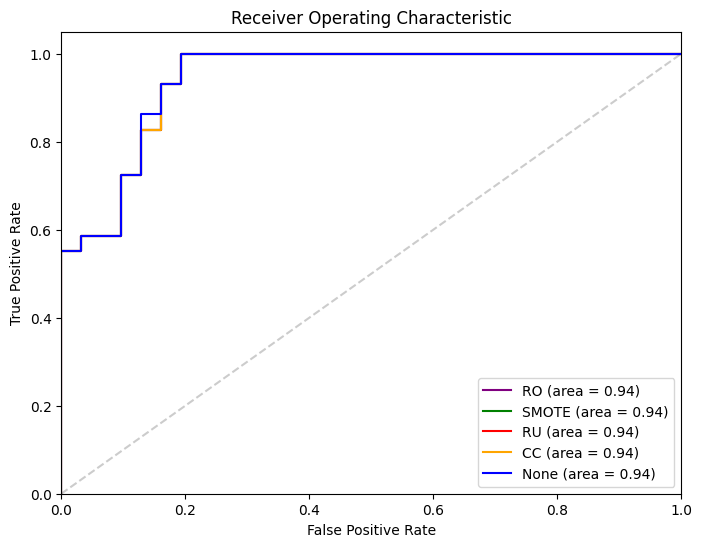

In [22]:
plt.figure(figsize=(8, 6))
colour_idx = 0 
colours = ['purple', 'green', 'red','orange','blue']

for name, (best_band,estimator, filter_b_a, best_W, _) in freqBandEstimators.items():
    probs = estimator.predict_proba(testData_motionIntent.iloc[:,:nCols-1])
    probs = probs[:, 1]  # use the probability of the positive class
    true_labels = testData_motionIntent.iloc[:,nCols-1]

    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(true_labels, probs)
    auc_score = auc(fpr, tpr)

    # Plot ROC curve for current model
    plt.plot(fpr, tpr, color=colours[colour_idx], label= name + ' (area = %0.2f)' % auc_score)
    colour_idx += 1

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"{name} resampler optimal threshold : {optimal_threshold}")

plt.plot([0, 1], [0, 1], 'k--',alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Ultimately, I think the choice of going with neither oversampling nor undersampling results in a more accurate assesment of generalizing
ability. Given the fact that the continuous EEG signals that will be fed into the sliding window classifier will not be balanced with respect to class distribution, choosing a model based on it's ability to generalize on an even distribution of samples would be a mistake.

In [22]:
_, bestEstimator_freq_band, (best_b,best_a), W_freq_band, allBandPerformanceMetrics = freqBandEstimators["SMOTE"]

#This ensemble classifier must be fit on training data with the specifically chosen frequency band





In [23]:
bestEstimator_freq_band

LinearDiscriminantAnalysis(shrinkage=0.30000000000000004, solver='lsqr')

In [24]:
motionIntentEnsemble = allBandPerformanceMetrics["accuracy"]["SVC_LR_LDA"][0]

In [25]:
motionIntentEnsemble

VotingClassifier(estimators=[('LinearDiscriminantAnalysis',
                              LinearDiscriminantAnalysis(shrinkage=0.30000000000000004,
                                                         solver='lsqr')),
                             ('SVC',
                              SVC(C=1, class_weight='balanced', gamma=1,
                                  probability=True)),
                             ('LogisticRegression',
                              LogisticRegression(C=1.5264179671752334,
                                                 class_weight='balanced',
                                                 penalty='l1',
                                                 solver='liblinear'))],
                 voting='soft', weights=[1, 2, 1])

### Person's Correlation Coefficient (PCC) + CSP

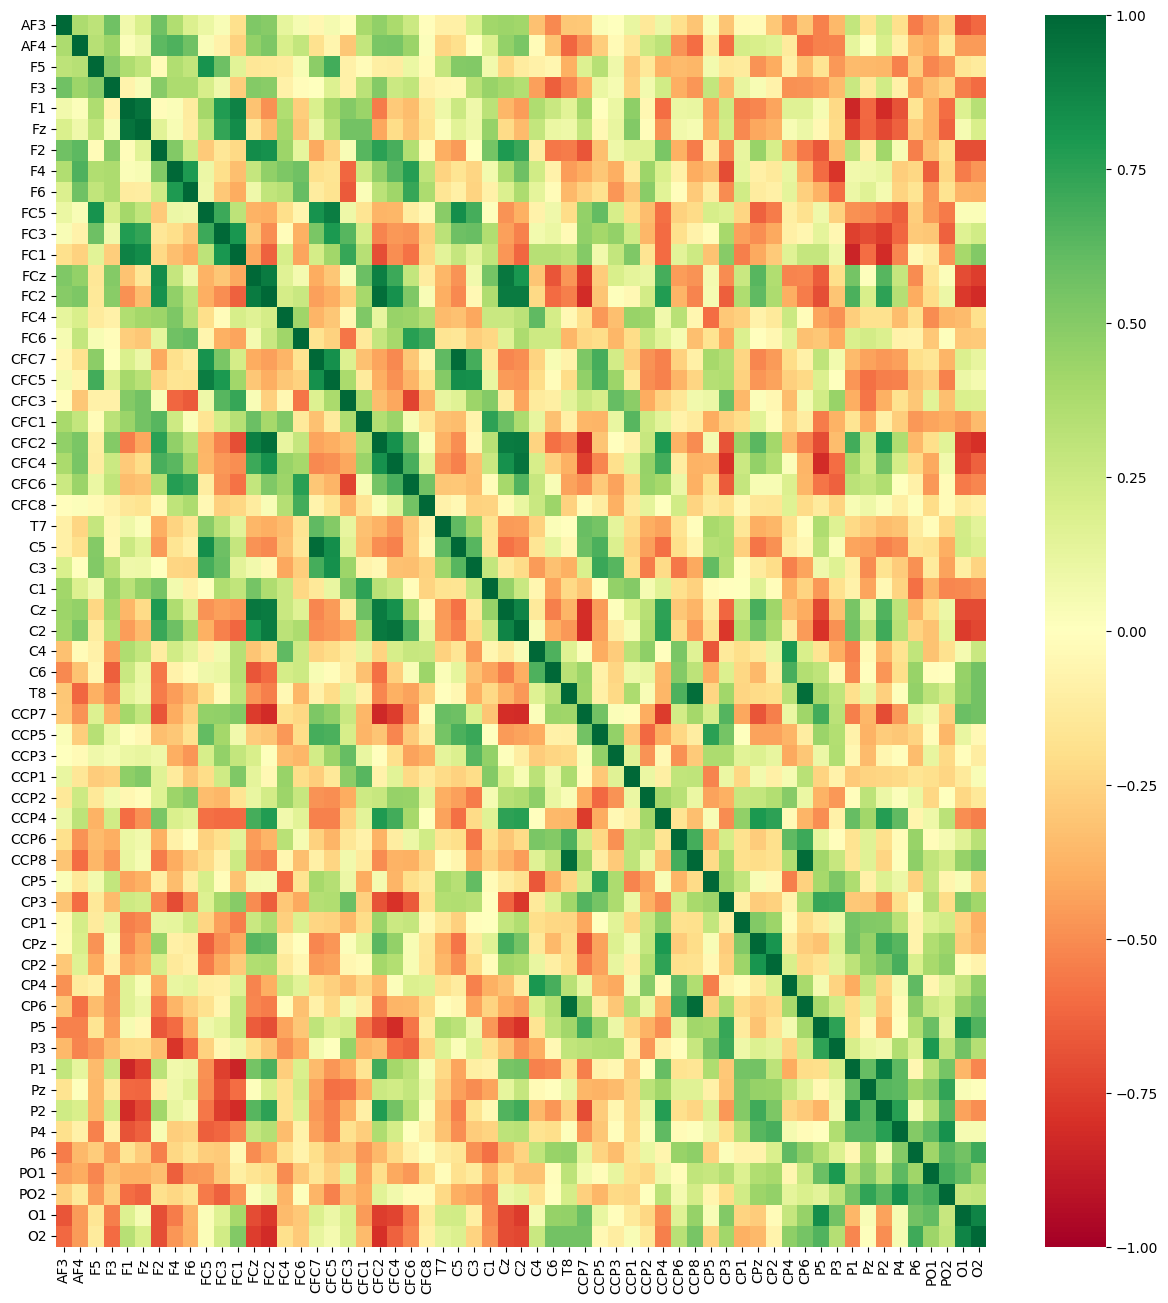

In [23]:
#Plot distributions of channels against eachother
# to find out if there is any sort of positive correlation
# between channels

import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
trialWin = np.arange(int(0*sRate),int(4*sRate))

# #get mixed trial data from original
trials_mixed = np.zeros(
            (nChannels, len(eventOnsets[0]), len(trialWin)))


for i, onset in enumerate(eventOnsets[0]):
    trials_mixed[:,i,:] = eeg[:,onset+trialWin]

# By augmenting the algorithm outlined in [ref: Electroencephalogram channel selection based on pearson correlation coefficient for motor imagery-brain-computer interface]
# we are able to extract the most correlated channels in the given data prior to selecting features with the CSP algorithm.


scaler = StandardScaler()

# For each trial
#We must standardize the values in each trial window for each channel (We use z-score normalization for this)
_, nTrials, _ = trials_mixed.shape

trialChannelCorrelations = []

plotFirst = False #flag to check that heatmap of first trial is plotted

for trial in range(nTrials):

    zTrial = scaler.fit_transform(trials_mixed[:,trial,:])
    corrMat = np.corrcoef(zTrial)

    if not plotFirst:
        plt.figure(figsize=(15, 16))
        sns.heatmap(pd.DataFrame(corrMat,columns=channelNames,index=channelNames),cmap="RdYlGn",vmin=-1,vmax=1)
        plotFirst = True

#     # We must then calculate the correlation matrices for each trial and return the mean for each row, giving us a vector of mean values
#     # which represents the average corellation values for a specific channel in relation to other channels.
    channelCorrValues = {ch:corrMean for (ch,corrMean) in zip(channelNames,np.mean(corrMat,axis=1))}

#     #Following the above referenced paper, we select the first 14 channels

    channelCorrValues = dict(sorted(channelCorrValues.items(), key=lambda x:x[1], reverse=True)[:14])
    trialChannelCorrelations.append(channelCorrValues)


<AxesSubplot: >

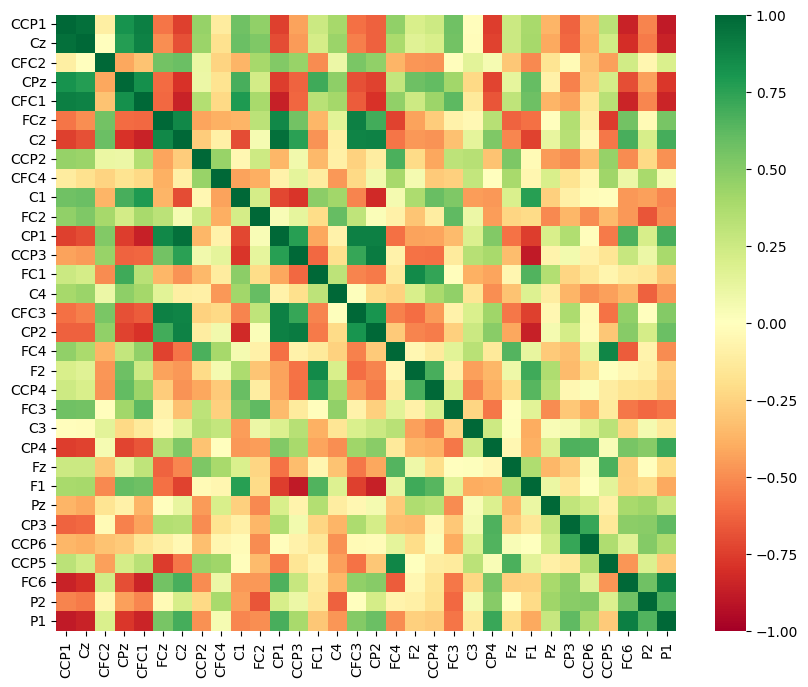

In [24]:
from collections import defaultdict

channelOccurences = defaultdict(int)

for dic in trialChannelCorrelations:
    for ch, _ in dic.items():
        channelOccurences[ch] += 1


# This represent the most correlated channels ordered (descending) by the number of time they appear
# in the most correlated channel list for each trial
channelOccurences = dict(sorted(channelOccurences.items(), key=lambda x:x[1], reverse=True))

selectedChannels = list(channelOccurences.keys())[:32]
# #It can be seen that all selected channels are in and around the sensorimotor cortex

selectedSet = set(selectedChannels)
selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

# #Plot heatmap of first trial
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(np.corrcoef(scaler.fit_transform(trials_mixed[selectedIdxs,0,:])),
            columns=selectedChannels,
            index=selectedChannels),
            cmap="RdYlGn",
            vmin=-1,
            vmax=1)



In [26]:

channelNums = dict()

for i in range(2,nChannels+1):
    selectedChannels = list(channelOccurences.keys())[:i]
    #It can be seen that all selected channels are in and around the sensorimotor cortex

    selectedSet = set(selectedChannels)
    selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

    bestEstimator_selected_channels = None

    bestAccVal, bestEstimator_selected_channels, _, _, _  =  testClassifier(dataB,
                                                                           0,
                                                                           4,
                                                                           0.7,
                                                                           [0,-1],
                                                                           [0,-1],
                                                                           b=best_b,
                                                                           a=best_a,
                                                                           selectedChannels=selectedIdxs,
                                                                           votingWeights=[1,2,1])


    channelNums[i] = bestAccVal #Test set performances


accuracy
---------

SVC
CV SCORE: 0.5928571428571427

-------------
LogisticRegression
CV SCORE: 0.5928571428571429

-------------
LinearDiscriminantAnalysis
cv score: 0.5571428571428572

-------------
SVC-LR-LDA
CV SCORE: 0.48571428571428577

-------------
accuracy
---------

SVC
CV SCORE: 0.55

-------------
LogisticRegression
CV SCORE: 0.5642857142857143

-------------
LinearDiscriminantAnalysis
cv score: 0.5428571428571429

-------------
SVC-LR-LDA
CV SCORE: 0.45714285714285713

-------------
accuracy
---------

SVC
CV SCORE: 0.6785714285714286

-------------
LogisticRegression
CV SCORE: 0.6714285714285715

-------------
LinearDiscriminantAnalysis
cv score: 0.6642857142857143

-------------
SVC-LR-LDA
CV SCORE: 0.6642857142857143

-------------
accuracy
---------

SVC
CV SCORE: 0.6642857142857144

-------------
LogisticRegression
CV SCORE: 0.6785714285714286

-------------
LinearDiscriminantAnalysis
cv score: 0.6571428571428571

-------------
SVC-LR-LDA
CV SCORE: 0.6571428571428573

In [27]:
bestEstimator_selected_channels

LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr')

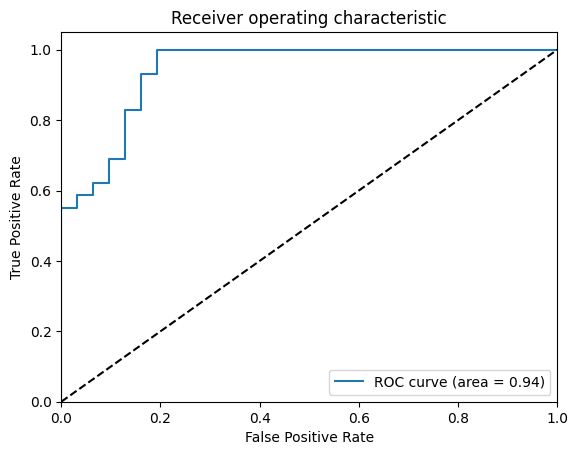

In [28]:
probs = bestEstimator_selected_channels.predict_proba(testData_motionIntent.iloc[:,:nCols-1])
probs = probs[:, 1]  # use the probability of the positive class
true_labels = testData_motionIntent.iloc[:,nCols-1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, probs)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


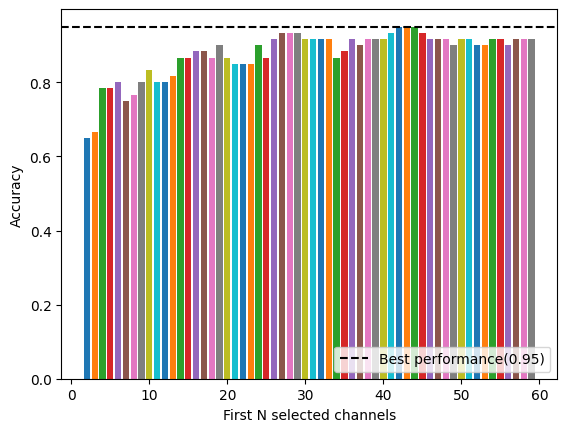

In [29]:
bestY = 0
for x, y in channelNums.items():
    bestY= max(bestY,y)
    plt.bar(x,y)

plt.xlabel("First N selected channels")
plt.ylabel("Accuracy")
plt.axhline(y=bestY, color='black', ls='--', lw=1.5, label=f"Best performance({bestY})")
plt.legend(loc='lower right')


### Calibration of best classifier to predict probability outputs for all time samples

In [32]:
evalDataB = scipy.io.loadmat("BCICIV_1eval_1000Hz_mat/BCICIV_eval_ds1b_1000Hz.mat")

In [33]:
bestEstimator_freq_band

LinearDiscriminantAnalysis(shrinkage=0.30000000000000004, solver='lsqr')

In [34]:
idlesStateClassifier
#SVC(C=1000, class_weight='balanced', gamma=0.1, probability=True)


SVC(C=1000, class_weight='balanced', gamma=0.1, probability=True)

In [35]:

from sklearn.calibration import CalibratedClassifierCV

bestEstimator_freq_band = CalibratedClassifierCV(bestEstimator_freq_band,cv="prefit")
bestEstimator_freq_band.fit(testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1])

motionIntentEnsemble = CalibratedClassifierCV(motionIntentEnsemble,cv="prefit")
motionIntentEnsemble.fit(testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1])


CalibratedClassifierCV(cv='prefit',
                       estimator=VotingClassifier(estimators=[('LinearDiscriminantAnalysis',
                                                               LinearDiscriminantAnalysis(shrinkage=0.30000000000000004,
                                                                                          solver='lsqr')),
                                                              ('SVC',
                                                               SVC(C=1,
                                                                   class_weight='balanced',
                                                                   gamma=1,
                                                                   probability=True)),
                                                              ('LogisticRegression',
                                                               LogisticRegression(C=1.5264179671752334,
                                                                                  class_weight='balanced',
                                                                                  penalty='l1',
                                                                                  solver='liblinear'))],
                                                  voting='soft',
                                                  weights=[1, 2, 1]))

In [36]:
probabilities, probabilities_ensemble = startRunningClassifier(evalDataB,
                                       bestEstimator_freq_band,
                                       idlesStateClassifier,
                                       motionIntentComp,
                                       idleStateComp,
                                       W_freq_band,
                                       W_idle_motionIntent,
                                       trialWinStart=0,
                                       trialWinEnd=4,
                                       b=best_b,
                                       a=best_a,
                                       idleStateEnsembleClassifer= idlestateEnsemble,
                                       calibratedEnsembleClassifier= motionIntentEnsemble)


In [39]:
import csv

with open("output_subject_b_1000Hz.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(probabilities)

with open("output_subject_b_1000Hz_ensemble.csv", "w") as e:
    wr = csv.writer(e)
    wr.writerows(probabilities_ensemble)


In [38]:
bestEstimator_freq_band.classes_

array([-1,  1])